<font size="5">directory and file import: 2208XX data</font>

In [533]:
from __future__ import division
import sys,os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
import scipy.optimize as opt
#import matplotlib.patches as mpatches
import h5py
sys.path.append('../PyMKID-master')
import PyMKID_USRP_functions as PUf
import PyMKID_resolution_functions as Prf
from scipy.signal import periodogram,get_window,coherence,welch,csd
import scipy.signal as sig
from scipy.interpolate import interp1d
import time 
import MB_equations as MBe
import MB_analysis as MBa
from matplotlib.lines import Line2D
from pandas import *
from importlib import reload

date_directory = '220822 laser data 3132/'

power_directories = ['-25/',\

                    ]


power_NDF_noise_files, power_NDF_pulse_files, power_NDF_pulse_vna_files, power_NDF_noise_vna_files, power_NDF_char_files = [], [], [], [], []
for power_directory in power_directories:
    NDF_noise_files, NDF_pulse_files, NDF_noise_vna_files,NDF_pulse_vna_files, NDF_char_files = [], [], [], [], []
    NDF_directories = []
    for _, dirs, _ in os.walk(date_directory + power_directory):
        for dirname in sorted(dirs,key=lambda x: -1*float(x[:x.find('V')])):
            NDF_directories.append(dirname)
    # NDF_directories = sorted(os.listdir(date_directory + power_directory))
    NDF_directories.append('')
    for NDF_directory in NDF_directories:
        directory = date_directory + power_directory + NDF_directory
        if NDF_directory != '':
            directory += '/'
        objects = sorted(os.listdir(directory))
        noise_counter = 0 
        for fm in range(len(objects)):
            if objects[fm][-3:] == '.h5':
                if 'USRP_Noise_' in objects[fm] and not 'cleaned' in objects[fm]:
                    NDF_noise_files += [directory + objects[fm]]
                elif '_VNA_' in objects[fm]:
                    NDF_pulse_vna_files += [directory + objects[fm]]
                    NDF_noise_vna_files += [directory + objects[fm]]
                elif 'USRP_Laser_' in objects[fm] and not 'cleaned' in objects[fm]:
                    NDF_pulse_files += [directory + objects[fm]]
                elif 'noise_averages' in objects[fm]:
                    NDF_char_files += [directory + objects[fm]]
    power_NDF_noise_files.append(NDF_noise_files)
    power_NDF_noise_vna_files.append(NDF_noise_vna_files)
    power_NDF_pulse_files.append(NDF_pulse_files)
    power_NDF_pulse_vna_files.append(NDF_pulse_vna_files)
    power_NDF_char_files.append(NDF_char_files)
print(NDF_directories)

['18V 50us', '17V 50us', '16V 50us', '15V 50us', '14V 50us', '13V 50us', '12V 50us', '11V 50us', '10V 50us', '9V 50us', '8V 50us', '7V 50us', '6V 50us', '5V 50us', '4V 50us', '3V 50us', '2V 50us', '1V 50us', '0V 50us', '']


<font size="5">noise cleaning to get cleaning coefficients</font>

will separate the data into  1000 chunks to achieve the requested 1.00e+02 lower end of the PSD
additional decimation by 5 needed to achieve the requested 5.00e+04 upper end of the PSD
doing additional decimation
sampling frequency plugged into welch is 50000
pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to 220822 laser data 3132/-25/USRP_Noise_20220822_140925.h5 because override=True!
found 3 pulses
chunk length plugged into welch is 500
chunked data into 1000 timestreams
computed electronics basis
cleaning...
(2, 349000)
(1, 349000)
(1, 349000)
(2, 349000)
(1, 349000)
(1, 349000)
saving clean_data to 220822 laser data 3132/-25/USRP_Noise_20220822_140925_cleaned.h5 because override=True!
number of chunks used to average is 698


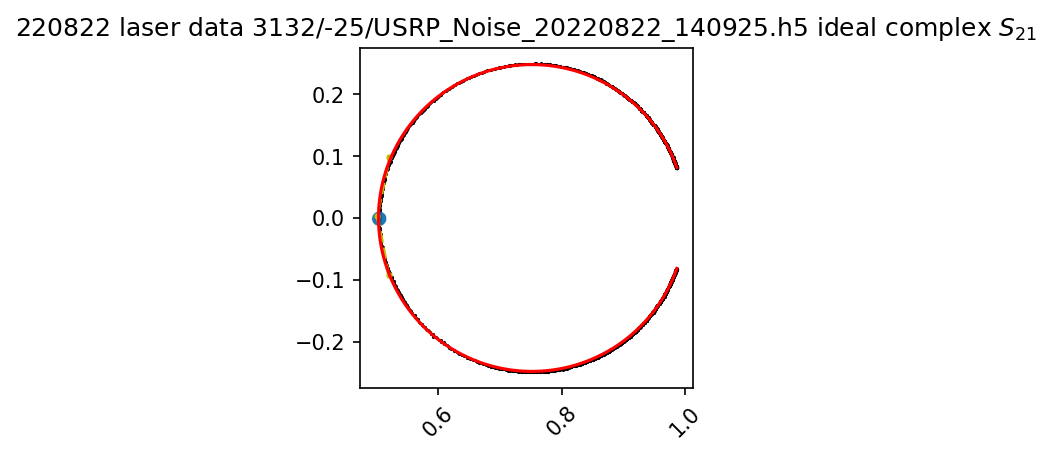

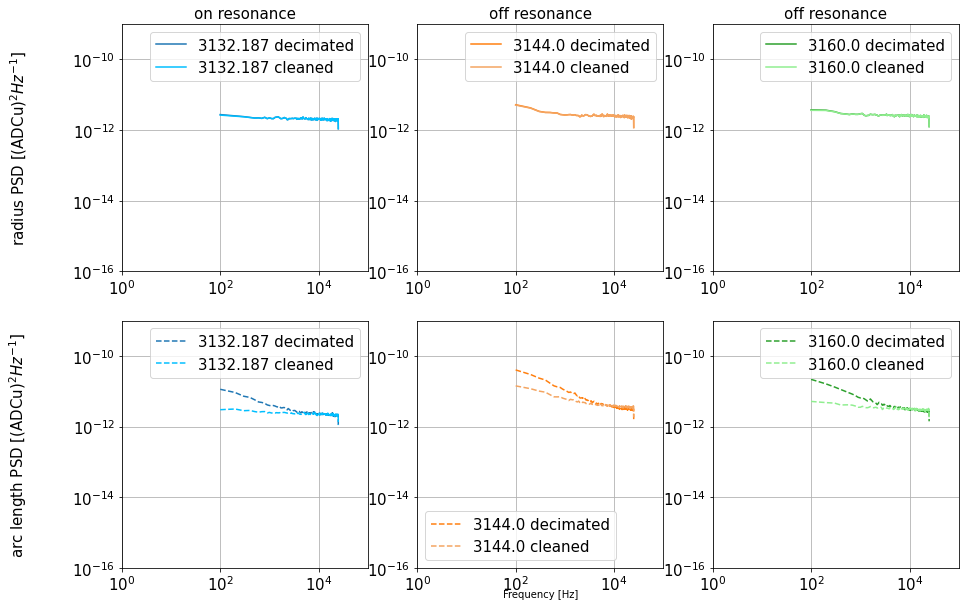

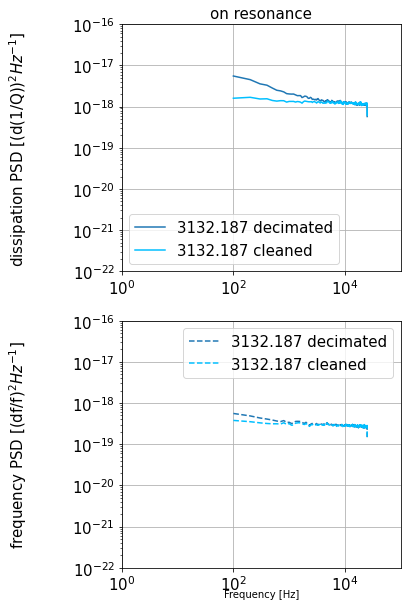

In [534]:
chunk_up_to = 1*10**2
decimate_down_to = 5*10**4
i = 0
reload(Prf); reload(PUf)
for noise_file,vna_file,char_file in zip(power_NDF_noise_files[0],power_NDF_noise_vna_files[0],power_NDF_char_files[0]):
    # print('\n\n\n\n\n\n\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`')
    # print('power: ' + power_directories[i])
    _, noise_info = PUf.unavg_noi(noise_file)
    noise_total_time =  noise_info['time'][-1]
    noise_fs = 1./noise_info['sampling period']
    noise_readout_f = noise_info['search freqs'][0]

    num_chunks = int(noise_total_time*chunk_up_to)
    noise_decimation = int(noise_fs/decimate_down_to)

    print('===================================')
    print('will separate the data into  ' + str(num_chunks) +  ' chunks to achieve the requested '  + "{:.2e}".format(chunk_up_to) + ' lower end of the PSD')
    print('===================================')
    print('additional decimation by ' + str(noise_decimation) +  ' needed to achieve the requested ' + "{:.2e}".format(decimate_down_to) + ' upper end of the PSD')
    print('===================================')

    with h5py.File(char_file,'r') as fyle:
        char_points = np.array(fyle['means'])
        char_f = np.array(fyle['frequencies'])
        readout_f = char_f[1]

    powers, PSDs, res, timestreams = Prf.PSDs_and_cleaning(noise_file,\
                                                           vna_file,\
                                                           extra_dec = noise_decimation,\
                                                           num_chunks=num_chunks,\
                                                           blank_chunks=int(num_chunks*0.3),\
                                                           removal_decimation = 1,\
                                                           char_fs=char_f,char_zs=char_points\
                                                           )
    i += 1

<font size="5">pulse cleaning</font>


cleaning pulse file: 220822 laser data 3132/-25/18V 50us/USRP_Laser_20220822_141010.h5
decimated data by 5 to achieve requested upper bound of 5.000000e+04 Hz
used 700 chunks to find quiescent point
saving clean_data to 220822 laser data 3132/-25/18V 50us/USRP_Laser_20220822_141010_cleaned.h5 because override=True!
220822 laser data 3132/-25/18V 50us/USRP_Laser_20220822_141010.h5
cleaning pulse file: 220822 laser data 3132/-25/17V 50us/USRP_Laser_20220822_141041.h5
decimated data by 5 to achieve requested upper bound of 5.000000e+04 Hz
used 700 chunks to find quiescent point
saving clean_data to 220822 laser data 3132/-25/17V 50us/USRP_Laser_20220822_141041_cleaned.h5 because override=True!
cleaning pulse file: 220822 laser data 3132/-25/16V 50us/USRP_Laser_20220822_141113.h5
decimated data by 5 to achieve requested upper bound of 5.000000e+04 Hz
used 700 chunks to find quiescent point
saving clean_data to 220822 laser data 3132/-25/16V 50us/USRP_Laser_20220822_141113_cleaned.h5 becaus

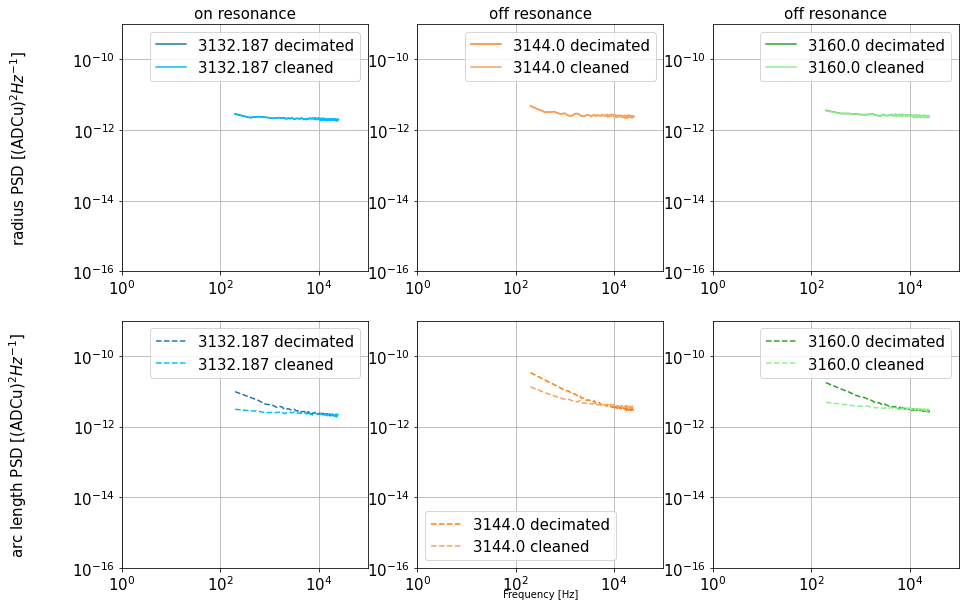

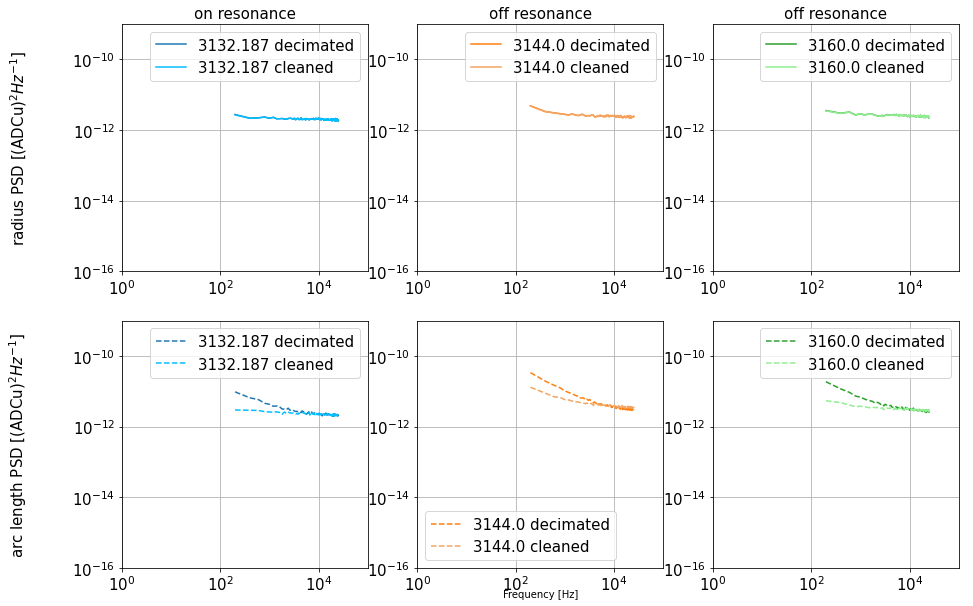

In [535]:
total_pulses = 100*10
decimate_down_to = 5e4
blank_fraction = 0.3
time_btw_pulse = 10e-3
num_pulses = int(total_pulses * (1 - blank_fraction))
# fraction_to_keep = 0.5

# num_pulses = 250*10
i = 0 
verbose = False
reload(Prf)
for NDF_pulse_files,NDF_noise_files,NDF_pulse_vna_file in zip(power_NDF_pulse_files,power_NDF_noise_files,power_NDF_noise_vna_files):
    # print('power: ' + power_directories[i])
    if len(NDF_pulse_files) != len(NDF_noise_files):
        NDF_noise_files = len(NDF_pulse_files) * NDF_noise_files
        NDF_pulse_vna_files = len(NDF_pulse_files) * NDF_pulse_vna_file
    j = 0
    for pulse_file,vna_file, noise_file in zip(NDF_pulse_files,NDF_pulse_vna_files,NDF_noise_files):
        print('===================')
        print('cleaning pulse file: ' + pulse_file)

        pulse_noise, pulse_info = PUf.unavg_noi(pulse_file)
        pulse_fs = 1./pulse_info['sampling period']
        pulse_cleaning_decimation = int(pulse_fs/decimate_down_to)
        
        if verbose:
            print('loaded pulse data')

        pulse_noise = Prf.average_decimate(pulse_noise,pulse_cleaning_decimation)
        pulse_fs /= pulse_cleaning_decimation
        
        print('decimated data by ' + str(pulse_cleaning_decimation) + ' to achieve requested upper bound of ' + '{:2e}'.format(decimate_down_to) + ' Hz' )

        samples_per_pulse = int(time_btw_pulse*pulse_fs)
        N = int(samples_per_pulse / 2)
        T = N/pulse_fs
        _,f = Prf.build_t_and_f(N,sampling_rate)
        pulse_start = int(total_pulses * blank_fraction)
        window_shift_seconds = -10e-6
        window_shift = int(window_shift_seconds * pulse_fs)
        noise_averages = np.zeros((3),dtype=np.complex128)
        J_r = np.zeros((N,3)); J_arc = np.zeros((N,3))
        k  = 0
        for pulse_i in range(pulse_start,int(total_pulses),1):                
            pulse_i_end = int((pulse_i+1)*samples_per_pulse) 
            no_pulse_idx_start = pulse_i_end - N + window_shift
            no_pulse_idx_end = pulse_i_end + window_shift
            no_pulse_chunk = pulse_noise[no_pulse_idx_start:no_pulse_idx_end,:]
            noise_averages += np.mean(pulse_noise[no_pulse_idx_start:no_pulse_idx_end,:],axis=0,dtype=np.complex128) / num_pulses    
            
            r_chunk,arc_chunk,_,_= Prf.electronics_basis(no_pulse_chunk)
            J_r += abs(Prf.discrete_FT(r_chunk))**2 / num_pulses * 2 * T
            J_arc += abs(Prf.discrete_FT(arc_chunk))**2 / num_pulses * 2 * T
            k += 1
        
        print('used ' + str(k) + ' chunks to find quiescent point')
        # if j % 4 == 0:
        #     fig, ax = plt.subplots(1,2,figsize=(5,10))
        #     ax[0].plot(f[f>0],J_r[f>0],color='C'+str(j%10))
        #     ax[1].plot(f[f>0],J_arc[f>0],color='C'+str(j%10))
        #     ax[0].set_yscale('log'); ax[0].set_xscale('log'); ax[1].set_yscale('log'); ax[1].set_xscale('log')
            
        # print(noise_averages)
        radius_averages = abs(noise_averages)
        angle_averages = np.angle(noise_averages)
        if verbose:
            print(radius_averages)
            print(angle_averages)

        pulse_timestream_rotated = pulse_noise*np.exp(-1j*angle_averages)
        angle_timestream = np.angle(pulse_timestream_rotated)

        radius = abs(pulse_noise) - radius_averages
        arc = angle_timestream*radius_averages

        radius_clean = np.zeros(radius.shape)
        arc_clean = np.zeros(arc.shape)

        if verbose:
            print('built radius and arc length timestreams given by quiescent point')

            print(noise_file)
        _,data_info = PUf.clean_noi(noise_file[:-3]+'_cleaned.h5')

        for t in range(radius.shape[1]):
            radius_coefficient = data_info['radius cleaning coefficient'][t]
            arc_coefficient = data_info['arc cleaning coefficient'][t]

            if t == 0:
                off_tone_idcs = [1,2]
            elif t == 1:
                off_tone_idcs = [2]
            elif t == 2:
                off_tone_idcs = [1]


            off_tone_radius = np.mean(radius[:,off_tone_idcs],axis=1,dtype=np.float64)
            radius_clean[:,t]= radius[:,t] - radius_coefficient*off_tone_radius

            off_tone_arc = np.mean(arc[:,off_tone_idcs],axis=1,dtype=np.float64)
            arc_clean[:,t] = arc[:,t] - arc_coefficient*off_tone_arc
            
            if verbose: 
                print('cleaned tone ' + str(t))

    #     print(np.mean(radius_clean))
        radius_clean -= np.mean(radius_clean,axis=0,dtype='float64')
        arc_clean -= np.mean(arc_clean,axis=0,dtype='float64')
    #     print(np.mean(radius_clean))
    #     print(radius_averages.shape, radius_clean.shape)
    #     data_clean = (radius_averages+radius_clean)#*np.exp(1j*((arc_clean/radius_averages)+angle_averages))
        # data_clean = (np.mean(abs(data_raw),axis=0,dtype=np.float64)+cd1_clean)*np.exp(1j*((cd2_clean/np.mean(abs(data_raw),axis=0,dtype=np.float64))+np.angle(np.mean(data_raw,axis=0,dtype=complex))))
        # print(cd1_coeff)

    #     data_clean_average = np.mean(data_clean,dtype='float64')
    #     print(abs(data_clean_average))
    #     print(np.angle(data_clean_average))

        pulse_noise_clean = Prf.save_clean_timestreams(pulse_file,\
                                                       radius_averages,\
                                                       angle_averages,\
                                                       radius_clean,\
                                                       arc_clean,\
                                                       pulse_fs,\
                                                       timestreams['radius coefficient'],\
                                                       timestreams['arc coefficient'],\
                                                       override=True)
        
        J_r_clean = np.zeros((N,3)); J_arc_clean = np.zeros((N,3))
        for pulse_i in range(pulse_start,int(total_pulses),1):                
            pulse_i_end = int((pulse_i+1)*samples_per_pulse) 
            no_pulse_idx_start = pulse_i_end - N + window_shift
            no_pulse_idx_end = pulse_i_end + window_shift
            no_pulse_chunk = pulse_noise_clean[no_pulse_idx_start:no_pulse_idx_end,:]
            
            r_chunk,arc_chunk,_,_= Prf.electronics_basis(no_pulse_chunk)
            J_r_clean += abs(Prf.discrete_FT(r_chunk))**2 / num_pulses * 2 * T
            J_arc_clean += abs(Prf.discrete_FT(arc_chunk))**2 / num_pulses * 2 * T
        
        
        J_r = J_r[f>=0]; J_r_clean = J_r_clean[f>=0]; J_arc = J_arc[f>=0]; J_arc_clean = J_arc_clean[f>=0]
        if j % 10 == 0:
            fig_0, axes_0 = plt.subplots(2,3,sharex=True,sharey='row',figsize=(5*3,10))
            print(pulse_file)
            Prf.plot_PSDs(f[f>0],J_r,J_arc,pulse_file,\
                          ['radius','arc length'],units=['ADCu','ADCu'],savefig='electronics',\
                          data_freqs=pulse_info['search freqs'],\
                          P_1_clean=J_r_clean,P_2_clean=J_arc_clean,\
                          fig_0=fig_0,axes_0=axes_0)
            # ax[0].plot(f[f>0],J_r[f>0],color='C'+str(j%10),ls='--')
            # ax[1].plot(f[f>0],J_arc[f>0],color='C'+str(j%10),ls='--')
            # ax[0].set_yscale('log'); ax[0].set_xscale('log'); ax[1].set_yscale('log'); ax[1].set_xscale('log')
            # ax[0].set_ylim([10**-16,10**-9]); ax[1].set_ylim([10**-16,10**-9])
        
        
        j += 1
    i += 1


<font size="5">pulse averaging</font>

power: -25/
averaging pulse file: 220822 laser data 3132/-25/18V 50us/USRP_Laser_20220822_141010.h5
Used 700 pulses to average
deleted an old pulse shape
averaging pulse file: 220822 laser data 3132/-25/17V 50us/USRP_Laser_20220822_141041.h5
Used 700 pulses to average
deleted an old pulse shape
averaging pulse file: 220822 laser data 3132/-25/16V 50us/USRP_Laser_20220822_141113.h5
Used 700 pulses to average
deleted an old pulse shape
averaging pulse file: 220822 laser data 3132/-25/15V 50us/USRP_Laser_20220822_141145.h5
Used 700 pulses to average
deleted an old pulse shape
averaging pulse file: 220822 laser data 3132/-25/14V 50us/USRP_Laser_20220822_141217.h5
Used 700 pulses to average
deleted an old pulse shape
averaging pulse file: 220822 laser data 3132/-25/13V 50us/USRP_Laser_20220822_141249.h5
Used 700 pulses to average
deleted an old pulse shape
averaging pulse file: 220822 laser data 3132/-25/12V 50us/USRP_Laser_20220822_141321.h5
Used 700 pulses to average
deleted an old pulse 

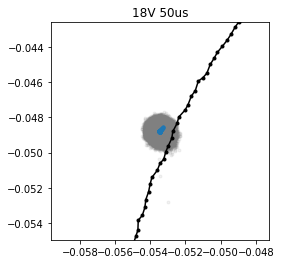

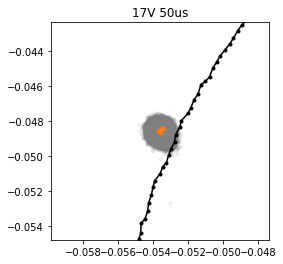

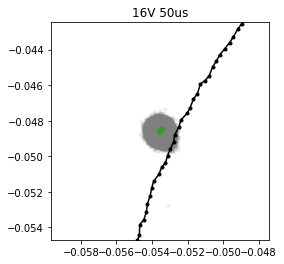

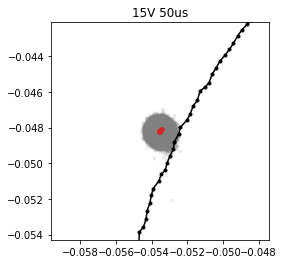

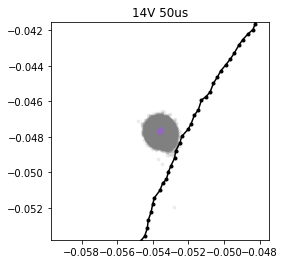

In [553]:
%matplotlib inline
NDF_pulse_avg = []
NDF_pulse_data_info = []
i = 0

fraction_to_keep = 0.5
window_shift_seconds = 100e-6
verbose = False
for NDF_pulse_files, NDF_pulse_vna_files in zip(power_NDF_pulse_files,power_NDF_pulse_vna_files):
    print('power: ' + power_directories[i])
    j = 0 
    if len(NDF_pulse_files) != len(NDF_pulse_vna_files):
        NDF_pulse_vna_files = len(NDF_pulse_files) * NDF_pulse_vna_files
    for pulse_file, vna_file in zip(NDF_pulse_files,NDF_pulse_vna_files):
        f,z = PUf.read_vna(vna_file)
        
        print('===================')
        print('averaging pulse file: ' + pulse_file)

        clean_pulse_file = pulse_file[:-3] + '_cleaned.h5'
        pulse_noise_clean,data_info = PUf.clean_noi(clean_pulse_file)
        if verbose: 
            print('loaded clean pulse data')        
            print('sampling_rate: ' + str(data_info['sampling_rate']))
        NDF_pulse_data_info.append(data_info)
        samples_per_pulse = data_info['sampling_rate'] * time_btw_pulse

        decimation = 1
        time = Prf.average_decimate(pulse_info['time'],decimation)
        pulse_noise_clean = Prf.average_decimate(pulse_noise_clean,decimation)
        samples_per_pulse_decimated = int(samples_per_pulse / decimation)
        sampling_rate = data_info['sampling_rate'] / decimation
        if verbose:
            print('further decimation by ' + str(decimation) + ' complete')

        # idcs_keep = np.zeros(int(num_pulses*samples_per_pulse_decimated*fraction_to_keep),dtype=int)
        pulse_avg = np.zeros(int(samples_per_pulse_decimated*fraction_to_keep),dtype=np.complex128)
        window_shift = int(window_shift_seconds*sampling_rate)
    #     print(pulse_avg)
        pulse_start = int(total_pulses * blank_fraction)
        # print(idcs_keep.shape)
        k = 0
        for pulse_i in range(pulse_start,int(total_pulses),1):
        #     print(pulse_i)
            pulse_idx_start = int(pulse_i*samples_per_pulse_decimated) + window_shift
            pulse_idx_end = int(round((pulse_i+fraction_to_keep)*samples_per_pulse_decimated,0)) + window_shift
        #     print(pulse_idx_start,pulse_idx_end)
            # print(np.arange(pulse_idx_start*2+samples_per_pulse,pulse_idx_end*2,1))
        #     print(pulse_idx_start*2+samples_per_pulse,pulse_idx_end*2)
            pulse_idx_list = np.arange(pulse_idx_start,pulse_idx_end,1,dtype=int)
        #     print(pulse_idx_list[0],pulse_idx_list[-1])
            pulse_avg += pulse_noise_clean[pulse_idx_list,0] / num_pulses
            k += 1
        if j == j:
            color = 'C' + str(j % 10)
            plt.figure()
            plt.plot(pulse_noise_clean[:,0].real,pulse_noise_clean[:,0].imag,ls='',marker='.',alpha=0.1,color='grey')
            plt.plot(pulse_avg.real,pulse_avg.imag,color=color,ls='-',marker='.')
            plt.plot(z.real,z.imag,color='k',ls='-',marker='.')
            width = 50 * np.std(pulse_noise_clean[:,0].real)
            x_c = np.mean(pulse_avg.real)
            y_c = np.mean(pulse_avg.imag)
            plt.axis([x_c - width/2., x_c + width/2., y_c-width/2., y_c+width/2.])
            ax = plt.gca(); ax.set_aspect('equal','box')
            plt.title(NDF_directories[j])
            # plt.savefig('noise and averaged pulse.png',dpi=100)
    #     print(pulse_avg)
        print('Used ' + str(k) + ' pulses to average')
            # print('===================')
        NDF_pulse_avg.append(pulse_avg)
        with h5py.File(clean_pulse_file, "a") as fyle:
            if 'pulse_shape' in fyle.keys():
                del fyle['pulse_shape']
                print('deleted an old pulse shape')
            fyle.create_dataset('pulse_shape',data = np.asarray(pulse_avg))
        j += 1
    i += 1


<font size="5">pulse rotation</font>

220822 laser data 3132/-25/18V 50us/USRP_Laser_20220822_141010.h5
220822 laser data 3132/-25/17V 50us/USRP_Laser_20220822_141041.h5
220822 laser data 3132/-25/16V 50us/USRP_Laser_20220822_141113.h5
220822 laser data 3132/-25/15V 50us/USRP_Laser_20220822_141145.h5
220822 laser data 3132/-25/14V 50us/USRP_Laser_20220822_141217.h5
220822 laser data 3132/-25/13V 50us/USRP_Laser_20220822_141249.h5
220822 laser data 3132/-25/12V 50us/USRP_Laser_20220822_141321.h5
220822 laser data 3132/-25/11V 50us/USRP_Laser_20220822_141353.h5
220822 laser data 3132/-25/10V 50us/USRP_Laser_20220822_141425.h5
220822 laser data 3132/-25/9V 50us/USRP_Laser_20220822_141457.h5
220822 laser data 3132/-25/8V 50us/USRP_Laser_20220822_141529.h5
220822 laser data 3132/-25/7V 50us/USRP_Laser_20220822_141601.h5
220822 laser data 3132/-25/6V 50us/USRP_Laser_20220822_141633.h5
220822 laser data 3132/-25/5V 50us/USRP_Laser_20220822_141705.h5
220822 laser data 3132/-25/4V 50us/USRP_Laser_20220822_141737.h5
220822 laser dat

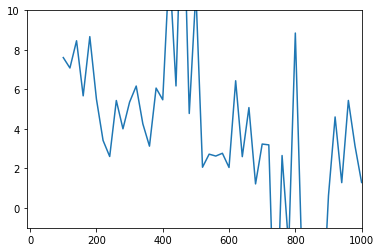

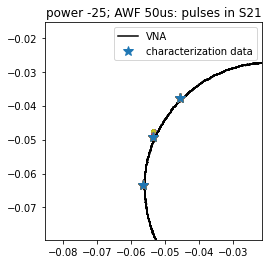

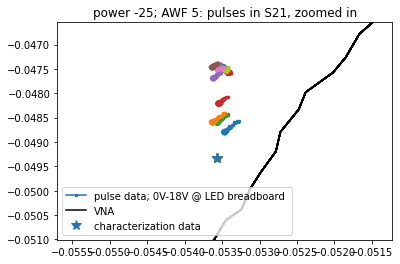

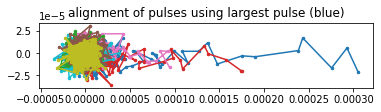

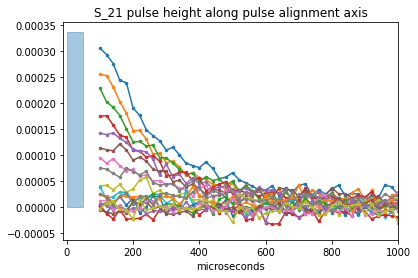

In [538]:
j = 0
reload(Prf)
for NDF_pulse_files,NDF_pulse_vna_files,NDF_char_files in zip(power_NDF_pulse_files,power_NDF_pulse_vna_files,power_NDF_char_files):
    i = 0
    # print(NDF_char_files)
    if len(NDF_pulse_files) != len(NDF_pulse_vna_files):
        NDF_char_files = len(NDF_pulse_files) * NDF_char_files
        NDF_pulse_vna_files = len(NDF_pulse_files) * NDF_pulse_vna_files
    last_width = 0.
    time_window_range = fraction_to_keep * time_btw_pulse *1e6
    time_window = np.arange(window_shift_seconds*1e6,time_window_range+window_shift_seconds*1e6,1/sampling_rate*1e6)
    for pulse_file,vna_file,char_file in zip(NDF_pulse_files,NDF_pulse_vna_files,NDF_char_files):
        print(pulse_file)
#         AWF_idx = pulse_file.find('us')
        
#         AWF_string = pulse_file[width_idx-2:width_idx+2]
        AWF_string = NDF_directories[1]
        title_1 = 'power ' + power_directories[j][:-1] + '; AWF ' + AWF_string[4:] + ': pulses in S21'
        title_1p5 = 'power ' + power_directories[j][:-1] + '; AWF ' + AWF_string[4] + ': pulses in S21, zoomed in'
        title_1p75 = 'alignment of pulses using largest pulse (blue)'
        # title_2 = 'power ' + power_directories[j][:-1] + ': timestream along rotated axis'    
        title_2 = 'S_21 pulse height along pulse alignment axis'
        clean_pulse_file = pulse_file[:-3] + '_cleaned.h5'
        with h5py.File(clean_pulse_file, "r") as fyle:
            pulse_avg = np.array(fyle["pulse_shape"],dtype=np.complex128)
            pulse_timestream = np.array(fyle["cleaned_data"],dtype=np.complex128)
        with h5py.File(char_file,'r') as fyle:
            char_points = np.array(fyle['means'])
            char_f = np.array(fyle['frequencies'])
            readout_f = char_f[0]
        f,z = PUf.read_vna(vna_file)

        # print(pulse_fs)
        df_f, d1_Q, _, _ = Prf.resonator_basis(pulse_avg,readout_f*1e-3,f*1e-3,z,char_f*1e-3,char_points)#,plot_title='power ' + power_directories[j][:-1] + ' AWF ' + AWF_string)
        df_f_timestream, d1_Q_timestream, _, _ = Prf.resonator_basis(pulse_timestream[:,0],readout_f*1e-3,f*1e-3,z,char_f*1e-3,char_points)
        # plt.axis([0.058, 0.062, -0.19, -0.15])
        
        pulse_avg_mb = pulse_avg - np.mean(pulse_avg[-5:],dtype=np.complex128)
        if i == 0:
            std = np.std(abs(pulse_avg_mb[-5:]),dtype=np.complex128)
            # average_angle = np.mean(np.angle(pulse_avg_mb[abs(pulse_avg_mb) > 5*std]))
            # average_angle = np.mean(np.angle(pulse_avg_mb[abs(pulse_avg_mb[time_window > 200]) > 5*std]))
            average_angle = np.mean(np.angle(pulse_avg_mb[np.logical_and(time_window>200,time_window<300)]))
        pulse_timestream_mb = pulse_timestream[:,0] - np.mean(pulse_avg[-5:],dtype=np.complex128)
                                             
        pulse_avg_rotated = pulse_avg_mb * np.exp(-1j*average_angle)
        pulse_timestream_rotated = pulse_timestream_mb * np.exp(-1j*average_angle)
        
        # template = df_f
        # noise = df_f_timestream
        
        template = pulse_avg_rotated.real #pulse_avg_rotated.real
        noise = pulse_timestream_rotated.real
        # print(len(pulse_avg),len(df_f))
        
        with h5py.File(clean_pulse_file, "a") as fyle:
            if 'df_f_template' in fyle.keys():
                del fyle['df_f_template']
            if 'df_f_pulse_noise' in fyle.keys():
                del fyle['df_f_pulse_noise']
            fyle.create_dataset('df_f_template',data = np.asarray(template))
            fyle.create_dataset('df_f_pulse_noise',data = np.asarray(noise))
        if i % 1 == 0:
            label_c = 'characterization data' if i == 0 else None
            label_V = 'VNA' if i == 0 else None
            label_p = 'pulse data; 0V-18V @ LED breadboard ' if i == 0 else None
            plt.figure(title_1)
            plt.plot(pulse_avg.real,pulse_avg.imag,ls='-',marker='.',markersize=5,color='C'+str(i%10))
            plt.plot(z.real,z.imag,color='k',label=label_V)
            plt.plot(char_points.real,char_points.imag,marker='*',markersize=10,ls='',label=label_c,zorder=-5*i+200)
            plt.axhline(0,color='grey')
            plt.axvline(0,color='grey')
            plt.title(title_1)
            width = 8e3 * np.std(pulse_avg.real)
            x_c = np.mean(pulse_avg.real)
            y_c = np.mean(pulse_avg.imag)
            plt.axis([x_c - width/2., x_c + width/2., y_c-width/2., y_c+width/2.])
            ax = plt.gca()
            ax.set_aspect('equal','box')
            plt.legend()
            
            plt.figure(title_1p5)
            plt.plot(pulse_avg.real,pulse_avg.imag,ls='-',marker='.',markersize=5,color='C'+str(i%10),label=label_p,zorder=-5*i+200)
            plt.plot(z.real,z.imag,color='k',label=label_V)
            plt.plot(char_points.real,char_points.imag,marker='*',markersize=10,ls='',label=label_c,zorder=-5*i+200)
            plt.title(title_1p5)
            
            if i == 0:
                width = 150 * np.std(pulse_avg.real)
                x_c = np.mean(pulse_avg.real)
                y_c = np.mean(pulse_avg.imag)
                plt.axis([x_c - width/2., x_c + width/2., y_c-width/2., y_c+width/2.])
                plt.legend()
            # plt.axis([0.055,0.06,-0.175,-0.17])
            # plt.axis([-0.025,-0.023,-0.031,-0.029])
            # plt.savefig('power_' + power_directories[j][:-1] + '_AWF_' + NDF_directories[i][:-1] + '_S21_100mK.png')
            
            if i % 3 == 0:
                plt.figure(title_1p75)
                plt.plot(pulse_avg_rotated.real,pulse_avg_rotated.imag,ls='-',marker='.',markersize=5,color='C'+str(i%10))
                ax = plt.gca()
                ax.set_aspect('equal', 'box')
                plt.title(title_1p75)
            
            
        
        AWF_idx = AWF_string.find('us')
        width = float(AWF_string[AWF_idx-3:AWF_idx])
        plt.figure(title_2)
        radius, arc_length, _, _ = Prf.electronics_basis(pulse_avg)
        # pulse_avg_plot = arc_length
        # pulse_avg_plot = pulse_avg.imag - np.mean(pulse_avg[:20].imag)
        pulse_avg_plot = template

        plt.plot(time_window,pulse_avg_plot,ls='-',marker='.',markersize=5,color='C'+str(i))
        # print((100+last_width,-4e-7),current_width-last_width)
        if i == 0:
            plot_max = max(pulse_avg_plot)
            ax = plt.gca()
            ax.add_patch(mpatches.Rectangle((0,0),width,plot_max*1.1,alpha=0.4,color='C'+str(i)))
        plt.xlim([window_shift_seconds-10, 1000])
        plt.xlabel('microseconds')
        plt.title(title_2)
        # plt.ylim([-4e-7,4e-7])
        
        if i == 0:
            stored_pulse = pulse_avg_rotated.real
        elif i == 8:
            current_pulse = pulse_avg_rotated.real
            ratio = stored_pulse / current_pulse
            plt.figure('ratio of pulses')
            plt.plot(time_window,ratio)
            plt.xlim([-10, 1000])
            plt.ylim([-1,10])

                   
        # plt.savefig('power_' + power_directories[j][:-1] + '_d1_Q_100mK.png')
        i += 1
    j += 1
    
directory = date_directory + power_directory
plt.figure(title_1)
plt.savefig(directory + 'VNA_char_pulse_S21.png',dpi=300,facecolor='white',transparent=False)
plt.figure(title_1p5)
plt.savefig(directory + 'VNA_char_pulse_S21_zoomed_in.png',dpi=300,facecolor='white',transparent=False)
plt.figure(title_1p75)
plt.savefig(directory + 'pulse_alignment.png',dpi=300,facecolor='white',transparent=False)
plt.figure(title_2)
plt.savefig(directory +'timestream_aligned',dpi=300,facecolor='white',transparent=False)




<font size="5">OF code</font>

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
power: -25
0.005
mu = 9.70e-01; sigma = 4.15e-01; sigma_0 = 3.318e-01
mu = 8.01e-01; sigma = 3.88e-01; sigma_0 = 3.318e-01
mu = 7.23e-01; sigma = 3.95e-01; sigma_0 = 3.318e-01
mu = 5.92e-01; sigma = 3.99e-01; sigma_0 = 3.318e-01
mu = 5.43e-01; sigma = 4.09e-01; sigma_0 = 3.318e-01
mu = 4.40e-01; sigma = 4.14e-01; sigma_0 = 3.318e-01
mu = 3.33e-01; sigma = 4.23e-01; sigma_0 = 3.318e-01
mu = 2.76e-01; sigma = 3.93e-01; sigma_0 = 3.318e-01
mu = 1.76e-01; sigma = 4.16e-01; sigma_0 = 3.318e-01
mu = 1.14e-01; sigma = 4.19e-01; sigma_0 = 3.318e-01
mu = 4.43e-02; sigma = 4.02e-01; sigma_0 = 3.318e-01
mu = 8.69e-02; sigma = 4.07e-01; sigma_0 = 3.318e-01
mu = 3.00e-02; sigma = 3.88e-01; sigma_0 = 3.318e-01
mu = -4.22e-02; sigma = 3.97e-01; sigma_0 = 3.318e-01


C:\Users\mkidc\AppData\Local\Temp\ipykernel_14828\2263551540.py:72: RuntimeWarning: overflow encountered in exp
  exponential = lambda x, A, tau: np.heaviside(x-time[t_offset(N)],1) * A * np.exp(-1*(x-time[t_offset(N)])/tau)


mu = -2.53e-02; sigma = 3.94e-01; sigma_0 = 3.318e-01
mu = -3.55e-02; sigma = 4.15e-01; sigma_0 = 3.318e-01
mu = 8.40e-04; sigma = 4.28e-01; sigma_0 = 3.318e-01
mu = 9.62e-02; sigma = 2.25e+00; sigma_0 = 3.318e-01
mu = -3.75e-03; sigma = 4.19e-01; sigma_0 = 3.318e-01
(19, 101)


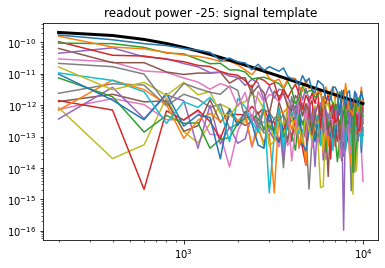

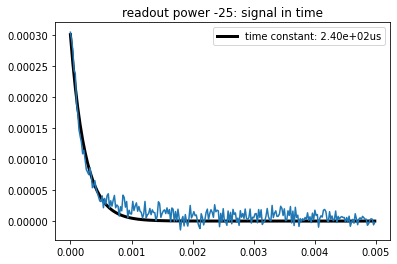

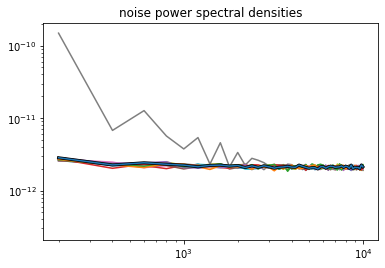

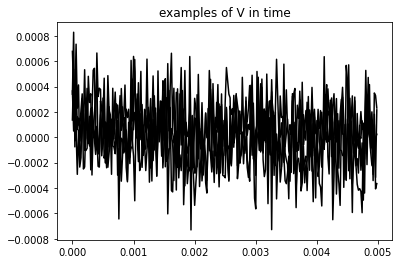

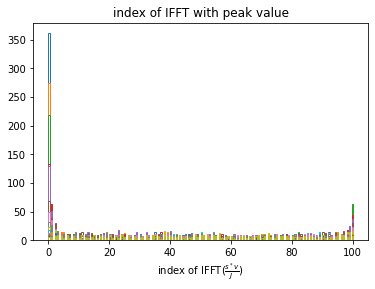

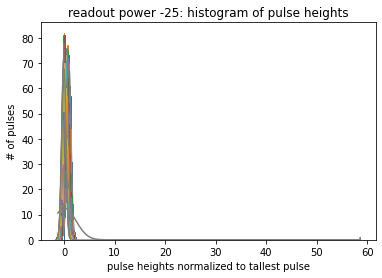

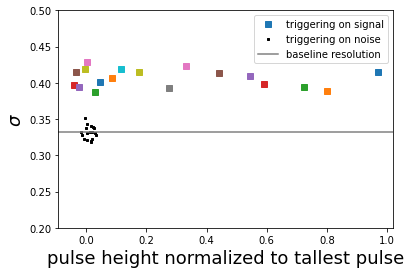

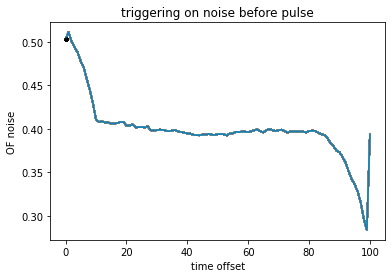

In [561]:
%matplotlib inline
from statistics import mode
import scipy
import numpy.fft as fft
reload(Prf)
i = 0
verbose = False
for NDF_pulse_files,NDF_pulse_vna_file in zip(power_NDF_pulse_files,power_NDF_pulse_vna_files):
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`')
#     print(power_directories,i)
    print('power: ' + power_directories[i][:-1])
    
    title_1 = 'readout power ' + power_directories[i][:-1] + ': signal template'
    title_1p5 = 'readout power ' + power_directories[i][:-1] + ': signal in time'
    title_2 = 'readout power ' + power_directories[i][:-1] + ': noise power spectral density'
    title_2 = 'noise power spectral densities'
    title_2p1 = 'examples of V in time'
    title_2p25  = 'convolution'
    title_2p5 = 'index of IFFT with peak value'
    title_3 = 'readout power ' + power_directories[i][:-1] + ': histogram of pulse heights'
    title_4 = 'readout power ' + power_directories[i][:-1] + ': sigma vs mu'
    
    clean_pulse_file = NDF_pulse_files[0][:-3] + '_cleaned.h5'
    with h5py.File(clean_pulse_file, "r") as fyle:
        N = len(np.array(fyle["df_f_template"]))
        sampling_rate = np.array(fyle['sampling_rate'])
    
    T = N/sampling_rate
    time, f = Prf.build_t_and_f(N,sampling_rate)
            
    f_max = 1e4
    f_mask = np.logical_and(f <= f_max, f >= -1*f_max)
    N_mask = len(f[f_mask])
    f_plot = np.logical_and(f > 0, f <= f_max)
    new_fs = max(f[f_mask])
    
    offset_exponent = np.zeros((N_mask,N_mask),dtype=np.complex128)
    time_ds = np.linspace(0,(N_mask-2)/(2*new_fs),N_mask)
    print((N_mask-1)/(2*new_fs))
    for j in range(N_mask):
        offset_exponent[j,:] = np.exp(1j*2*np.pi*f[f_mask][j]*time_ds)
        
    for j in range(N_mask):
        for k in range(N_mask):
            if abs(offset_exponent[j,k].real) < 1e-10:
                offset_exponent[j,k] = 1j*offset_exponent[j,k].imag
            if abs(offset_exponent[j,k].imag) < 1e-10:
                offset_exponent[j,k] = offset_exponent[j,k].real
    
    mu = np.zeros((len(NDF_pulse_files),N_mask))
    sigma = np.zeros((len(NDF_pulse_files),N_mask))
    j = 0
    s_found = False
    for pulse_file in NDF_pulse_files:
        if verbose: 
            print('=====================')
            print('analyzing data file: ' + pulse_file)
        color = 'C'+str(j%10)
#         print(pulse_file)
        clean_pulse_file = pulse_file[:-3] + '_cleaned.h5'
        with h5py.File(clean_pulse_file, "r") as fyle:
            pulse_avg = np.array(fyle["df_f_template"])            
            pulse_noise = np.array(fyle["df_f_pulse_noise"])

    #     pulse_avg = np.polyval(dtheta_to_energy_fit,pulse_avg)
    #     pulse_noise = np.polyval(dtheta_to_energy_fit,pulse_noise)
        t_offset = lambda N: 0 #N//2
        # t_offset = lambda N: 0
        pulse_recentered = np.concatenate((pulse_avg[t_offset(N):],pulse_avg[:t_offset(N)]))
        # pulse_recentered = np.concatenate(np.zeros())
        w = scipy.signal.blackman(N_mask)
        exponential = lambda x, A, tau: np.heaviside(x-time[t_offset(N)],1) * A * np.exp(-1*(x-time[t_offset(N)])/tau)
        # exponential = lambda x, A, tau_qp: A * np.exp(-1*x/tau)
        popt,_ = opt.curve_fit(exponential,time,pulse_recentered,[1.2e-4,50e-6])
        pulse_fit = exponential(time,*popt)
        s_temp = Prf.discrete_FT(pulse_recentered)
        if j == 0:
            A = np.trapz(pulse_fit,dx = time[1]-time[0])
            # s = Prf.discrete_FT(pulse_fit/A)
            # s = fft.ifft(pulse_recentered) / max(pulse_recentered)
            s = Prf.discrete_FT(pulse_fit)#/max(pulse_recentered))
        # if j <= len(NDF_pulse_files)-5:
            plt.figure(title_1)
            S_mag = abs(s[f_mask]**2)
            plt.plot(f[f_plot],abs(s[f_plot]**2),zorder=-5*j+5,color='k',linewidth=3)
            plt.figure(title_1p5)
            plt.plot(time,pulse_fit,'k',linewidth=3,label='time constant: {:.2e}us'.format(popt[1]*1e6) )
            plt.plot(time,pulse_recentered)
            plt.legend()
        plt.figure(title_1)
        plt.plot(f[f_plot],abs(s_temp[f_plot]**2),zorder=-5*j+5,color=color)

    #     pulse_filter = pulse_avg[::-1]/max(pulse_avg)
    #     plt.figure(10)
    #     plt.plot(pulse_filter,zorder=100-5*i)
    #     filtered_data = scipy.signal.fftconvolve(pulse_noise, pulse_filter, mode="valid")

    #     time = np.linspace(0,len(filtered_data)/sampling_rate,len(filtered_data))
    #     print(time,filtered_data)
    #     plt.figure(1)
    #     plt.plot(time,filtered_data)
    #     plt.xlim([4.005,4.010])
        
        samples_per_pulse = sampling_rate*time_btw_pulse
        window_shift_J = -10e-6
        window_shift_J_idx = int(window_shift_J*sampling_rate)
        J_temp = np.zeros(N)
        # for pulse_i in range(num_pulses):
        for pulse_i in range(pulse_start,int(total_pulses),1):                
            pulse_i_end = int((pulse_i+1)*samples_per_pulse) 
            no_pulse_idx_start = pulse_i_end - N + window_shift_J_idx
            no_pulse_idx_end = pulse_i_end + window_shift_J_idx
            no_pulse_idx_list = np.arange(no_pulse_idx_start,no_pulse_idx_end,1,dtype=int)
            no_pulse_noise_i = pulse_noise[no_pulse_idx_list]
            # if pulse_i == 0:
            #     print(time[no_pulse_idx_start])

            J_temp += abs(Prf.discrete_FT(no_pulse_noise_i))**2 / num_pulses * 2 * T
            # J_temp += abs(fft.ifft(no_pulse_noise_i))**2 / num_pulses * 2 * T
            
        if j == 0:
            J = J_temp
            plt.figure(title_2)
            plt.plot(f[f_plot],J[f_plot],zorder=-5*j+5,color='k',linewidth=3)
        else:
            plt.figure(title_2)
            plt.plot(f[f_plot],J_temp[f_plot],zorder=-5*j+5,color=color)
            
            
        plt.figure(title_2)
        plt.plot(f[f_plot],J[f_plot],zorder=-5*j+5,color=color)
        denominator = np.sum(abs(s[f_mask])**2/J[f_mask])


        A_hat = np.zeros((num_pulses,N_mask))
        A_max_idx = np.zeros(num_pulses)
        A_hat_max = np.zeros(num_pulses)
        A_hat_sum = np.zeros(num_pulses)
        # numerator_sum = np.zeros(N_mask)

        b7_res = np.sqrt(((2*T*denominator)**-1))
        k = 0
        t_offset_idx = t_offset(N_mask)
        for pulse_i in range(pulse_start,int(total_pulses),1):
            pulse_i_start = int(pulse_i*samples_per_pulse)
            pulse_idx_start = pulse_i_start + window_shift
            pulse_idx_end = pulse_idx_start + N
            pulse_idx_list = np.arange(pulse_idx_start,pulse_idx_end,1,dtype=int)
            pulse_noise_i = pulse_noise[pulse_idx_list]
            # pulse_noise_i_recentered = np.concatenate((pulse_noise_i[N//2:],pulse_noise_i[:N//2]))

            v = Prf.discrete_FT(pulse_noise_i - np.mean(pulse_noise_i[-5:])) 
            # v_ps = abs(v)**2 
            # v_ps = v[f_plot]
            # v = fft.fft(pulse_noise_i - np.mean(pulse_noise_i[-5:])) / N_mask

            
            pulse_i_end = int((pulse_i+1)*samples_per_pulse) 
            no_pulse_idx_start = pulse_i_end - N + window_shift_J_idx
            no_pulse_idx_end = pulse_i_end + window_shift_J_idx
            no_pulse_idx_list = np.arange(no_pulse_idx_start,no_pulse_idx_end,1,dtype=int)
            no_pulse_noise_i = pulse_noise[no_pulse_idx_list]
            v_temp = Prf.discrete_FT(no_pulse_noise_i)

                        
            if j == 0 and (pulse_i + 2) % 200 == 0:
                plt.figure(title_2p1)
                # plt.plot(time,no_pulse_noise_i,color='grey')
                plt.plot(time,pulse_noise_i,color='k')
                
            numerator = Prf.discrete_IFT(np.conj(s[f_mask])*v[f_mask]/J[f_mask])
            numerator = numerator.real
            
            numerator_sum = sum(offset_exponent[:,t_offset_idx]*np.conj(s[f_mask])*v_temp[f_mask]/J[f_mask])
            numerator_sum = numerator_sum.real
            # if pulse_i % 100 == 0: 
            #     print(numerator_sum)
#             if pulse_i % 50 == 0:
#                 idx_range = 20
#                 plt.plot(np.arange(-idx_range,0,1),numerator[-idx_range:]/denominator,ls='',marker='.',color=color)
#                 plt.plot(np.arange(0,idx_range,1),numerator[:idx_range]/denominator,ls='',marker='.',color=color)
            
            max_numerator = max(numerator)
            max_idx = np.argwhere(numerator == max_numerator)
        
            A_max_idx[k] = max_idx 
            A_hat[k,:] = numerator / denominator
            
            A_hat_max[k] = max_numerator/denominator
            
            A_hat_sum[k] = numerator_sum / denominator
            k += 1
        
    
        for k in range(N_mask):
            (mu[j,k], sigma[j,k]) = scipy.stats.norm.fit(A_hat[:,k])
        # optimal_t0 = t_offset(N_mask)
        if j == 0:
            # optimal_t0 = int(mode(A_max_idx))
            optimal_t0 = t_offset_idx
        (mu_max, sigma_max) = scipy.stats.norm.fit(A_hat_max)
        (mu_sum, sigma_sum) = scipy.stats.norm.fit(A_hat_sum)
        print('mu = ' + "{:.2e}".format(mu[j,t_offset_idx]) + '; sigma = ' + "{:.2e}".format(sigma[j,t_offset_idx])+ '; sigma_0 = ' + "{:.3e}".format(b7_res))
#         try:            
        if not 'no NDF' in pulse_file:
            plt.figure(title_2p5)
            n, bins, patches = plt.hist(A_max_idx,bins=N,fill=False,histtype='step',label='radians',color=color)
            if j % 1 == 0:
                plt.figure(title_3)
                if j == 0:
                    n, bins, patches = plt.hist(A_hat[:,optimal_t0],bins=25,fill=False,histtype='step',label='radians',color=color)
                    bin_width = bins[1]-bins[0]
                else:
                    data = A_hat[:,optimal_t0]
                    n, bins, patches = plt.hist(data,bins=np.arange(min(data), max(data) + bin_width, bin_width),fill=False,histtype='step',label='radians',color=color)
                plt.plot(np.linspace(bins[0],bins[-1],100),\
                         len(A_hat)*(bins[1]-bins[0])*scipy.stats.norm.pdf(np.linspace(bins[0],bins[-1],100),mu[j,optimal_t0],sigma[j,optimal_t0]),\
                         c='gray')

            # mu2s.append(mu2); sigma2s.append(sigma2)
            # mus.append(np.mean(mu)); sigmas.append(np.mean(sigma))

            plt.figure(title_4)
            if j == 0:
                label1 = 'triggering on signal'
                label2 = 'triggering on noise'
            else:
                label1 = None
                label2 = None
            plt.plot(mu[j,optimal_t0],sigma[j,optimal_t0],color=color,ls='',marker='s',label=label1)
            plt.plot(mu_sum,sigma_sum,ls='',marker='s',color='k',markersize=2,label=label2)
            # plt.plot(mu2,sigma2,color=color,ls='',marker='x')
            # plt.plot(mu_sum,sigma_sum,color='k',ls='',marker='s',markersize=2)


#         except:
#             pass
        j += 1
        
    plt.figure(title_1)
    ax = plt.gca(); ax.set_yscale('log'); ax.set_xscale('log')
    plt.title(title_1)
    
    plt.figure(title_1p5)
    plt.title(title_1p5)
    
    plt.figure(title_2)
    ax = plt.gca(); ax.set_yscale('log'); ax.set_xscale('log')
    J_avg = np.mean(J)
    plt.ylim([1e-1*J_avg,1e2*J_avg])
    plt.title(title_2)
    
    plt.figure(title_2p1)
    plt.title(title_2p1)
    
    plt.figure(title_2p5)
    plt.title(title_2p5)
    plt.xlabel(r'index of IFFT($\frac{s^*v}{J}$)')
    
    plt.figure(title_3)
    plt.title(title_3)
    plt.xlabel('pulse heights normalized to tallest pulse')
    plt.ylabel('# of pulses')
#     plt.xlim([-0.25,0.5])
    # ax = plt.gca(); ax.set_yscale('log');
    # plt.ylim([10**-1,10**3])

    plt.figure(title_4)
#     plt.title(title_4)
    plt.axhline(b7_res,color='grey',label='baseline resolution')
    plt.xlabel('pulse height normalized to tallest pulse',fontsize=18)
    plt.ylabel('$\sigma$',fontsize=18)
    plt.legend()
    plt.ylim([0.2,0.5])
    
    plt.figure()
    print(sigma.shape)
    for j in range(N_mask):
        plt.plot(np.mean(sigma,axis=0))
        plt.plot(optimal_t0,np.mean(sigma[:,optimal_t0]),ls='',marker='.',color='k')
    # print(np.mean(np.mean(sigma[-8:])))
    plt.xlabel('time offset')
    plt.ylabel('OF noise')
    plt.title('triggering on noise before pulse')
    # plt.savefig('triggering_on_noise_after_pulse',dpi=300,facecolor='white',transparent=False)
    
    def sig(mu,sigma_0,r):
        return np.sqrt(sigma_0**2 + (mu)*r)

    import scipy
    p0 = [1e-1,1e-2]
    # f_fit_vals,_ = scipy.optimize.curve_fit(f,mu[:,],sigmas[1:],p0,bounds=[(15*(0.008/2.6),7e-3),(40*(0.008/2.6),0.1)])
#     f_fit_vals,_ = scipy.optimize.curve_fit(f,mus[1:],sigmas[1:],p0)
#     f_fit_vals1,_ = scipy.optimize.curve_fit(f,mu1s[1:],sigma1s[1:],p0)
#     f_fit_vals2,_ = scipy.optimize.curve_fit(f,mu2s[1:],sigma2s[1:],p0)
#     #     for i in range(len(mus)):
#     #         print(f_fit_vals[0],mus[i]*f_fit_vals[1])

#     sigma_0_E_pub = abs(f_fit_vals[0])/(f_fit_vals[1]/2.6)
#     r_E = f_fit_vals[1]/2.6
#     print('energy resolution estimate is: ' + str(sigma_0_E_pub))
#     sigma_0_E = abs(f_fit_vals1[0])/(f_fit_vals1[1]/2.6)
#     r_E = f_fit_vals1[1]/2.6
#     print(sigma_0_E)
#     sigma_0_E = abs(f_fit_vals2[0])/(f_fit_vals2[1]/2.6)
#     r_E = f_fit_vals2[1]/2.6
#     print(sigma_0_E)

    # mu_plot = np.linspace(0,0.25,100)
#     plt.figure(title_4)
#     plt.plot(mus,np.array(sigmas))
#     plt.plot(mu_plot,f(mu_plot,*f_fit_vals),label='$\sigma_0$='+str(round(sigma_0_E_pub,1))+'eV')
#     custom_lines = [\
#                 #Line2D([0], [0],color='k',ls='',marker='.',label='max of IFT'),\
#                 #Line2D([0], [0], color='k',alpha=0.5, ls='dashdot',label='radius and arc length directions'),\
#                 Line2D([0], [0],color='k',ls='',marker='s',label='index 0'),]
#                 #Line2D([0], [0], ls='',color='C1', marker='.',label='off resonance timestream')]
# #     plt.legend(handles=custom_lines)
#     plt.legend(loc='lower right',fontsize=14)
#     plt.ylim([0,0.05])
#     plt.tight_layout()
#     plt.savefig('sigma_vs_mu.png',dpi=200)
#     plt.plot(mu1s,sigma1s)
#     plt.plot(mu_plot,f(mu_plot,*f_fit_vals1))
#     plt.plot(mu2s,sigma2s)
#     plt.plot(mu_plot,f(mu_plot,*f_fit_vals2))
    i += 1

In [514]:
help(np.arange)

Help on built-in function arange in module numpy:

arange(...)
    arange([start,] stop[, step,], dtype=None, *, like=None)
    
    Return evenly spaced values within a given interval.
    
    Values are generated within the half-open interval ``[start, stop)``
    (in other words, the interval including `start` but excluding `stop`).
    For integer arguments the function is equivalent to the Python built-in
    `range` function, but returns an ndarray rather than a list.
    
    When using a non-integer step, such as 0.1, it is often better to use
    `numpy.linspace`. See the warnings section below for more information.
    
    Parameters
    ----------
    start : integer or real, optional
        Start of interval.  The interval includes this value.  The default
        start value is 0.
    stop : integer or real
        End of interval.  The interval does not include this value, except
        in some cases where `step` is not an integer and floating point
        round-off 

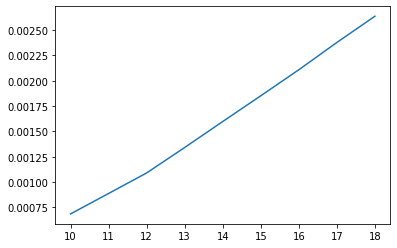

In [486]:
plt.plot(np.linspace(18,10,9),mu[:,t_offset(N_mask)])